### Overall Flow

1. Problem Definition
2. Data Crunching
3. Data Processing
4. EDA
5. Model Building (Model may refer to any proposed solution: Feature change; rule based; DNN; ML)
6. Model Evaluation
7. Model Deployment
8. Model Monitoring
9. Feedback Loop

### Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
SEED = 19

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import os
import sys

In [5]:
import pandas as pd
import numpy as np

In [6]:
from sklearn.preprocessing import StandardScaler

from scipy.spatial.distance import cdist
from scipy.spatial.distance import pdist

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

In [7]:
from visualize_silehoutte import *

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
%matplotlib inline

### Reading data

In [9]:
INPUT_FILE = "Credit Card Customer Data.xlsx"
INPUT_PATH="./"
OUTPUT_PATH="./results"

In [10]:
def read_data(input_dir, input_file):
    
    input_file_ext = input_file.split(".")[-1]
    
    if input_file_ext == "xlsx":
        df = pd.read_excel(os.path.join(INPUT_PATH, INPUT_FILE))
    
    return df

In [11]:
df = read_data(INPUT_PATH, INPUT_FILE)

In [12]:
df.shape

(660, 7)

In [13]:
df.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


### Sanity Check 1

In [14]:
def sanity_check_1(df):
    dtype = df.dtypes
    null = df.isnull().sum()
    unique = df.nunique()

    result_df = pd.concat([dtype, null, unique], axis=1)
    result_df.columns = ['dtype', 'null', 'unique']
    result_df['null_%'] = result_df['null'].values / len(df)
    
    
    return result_df

In [15]:
sanity_df = sanity_check_1(df)

In [17]:
sanity_df.to_csv(os.path.join(OUTPUT_PATH, "sanity.csv"))

In [18]:
sanity_df

,dtype,null,unique,null_%
Sl_No,int64,0,660,0.0
Customer Key,int64,0,655,0.0
Avg_Credit_Limit,int64,0,110,0.0
Total_Credit_Cards,int64,0,10,0.0
Total_visits_bank,int64,0,6,0.0
Total_visits_online,int64,0,16,0.0
Total_calls_made,int64,0,11,0.0


- Check all columns have expected data type
- Integer are not read as float, or str
- Dates




- It saves space
- specifying datatype enables reading data faster

### Duplicated Customers

In [21]:
df.duplicated(subset=['Customer Key']).sum()

5

In [19]:
customer_counts = df['Customer Key'].value_counts()
customer_counts_gt_1 = customer_counts[customer_counts>1]
len(customer_counts_gt_1)

5

In [22]:
duplicated_customer = customer_counts_gt_1.index.tolist()

In [23]:
duplicated_customer

[47437, 37252, 97935, 96929, 50706]

In [24]:
df[df['Customer Key'].isin(duplicated_customer)].sort_values(by=['Customer Key','Sl_No'])

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
48,49,37252,6000,4,0,2,8
432,433,37252,59000,6,2,1,2
4,5,47437,100000,6,0,12,3
332,333,47437,17000,7,3,1,0
411,412,50706,44000,4,5,0,2
541,542,50706,60000,7,5,2,2
391,392,96929,13000,4,5,0,0
398,399,96929,67000,6,2,2,2
104,105,97935,17000,2,1,2,10
632,633,97935,187000,7,1,7,0


- There can be many reaosns of duplication
- Correction appended
- Wrong Customer Key entered
- Talk to Business team to know specific reason

In [25]:
df.sort_values(by='Sl_No', inplace=True)

In [26]:
df.drop_duplicates(subset=['Customer Key'],
                   keep='last',
                  inplace=True)

In [27]:
df.shape

(655, 7)

### Univariate Distribution

In [28]:
univariate_df = pd.concat([df.describe().T, df.skew()], axis=1)
univariate_df.rename(columns={0:"skew"}, inplace=True)

In [29]:
univariate_df

,count,mean,std,min,25%,50%,75%,max,skew
Sl_No,655.0,331.552672,190.407385,1.0,167.5,331.0,496.5,660.0,-0.001643
Customer Key,655.0,55058.158779,25606.965469,11265.0,33623.5,53898.0,77084.5,99843.0,0.048520
Avg_Credit_Limit,655.0,34563.358779,37648.200947,3000.0,10000.0,18000.0,48000.0,200000.0,2.209182
Total_Credit_Cards,655.0,4.711450,2.172410,1.0,3.0,5.0,6.0,10.0,0.140402
Total_visits_bank,655.0,2.404580,1.625385,0.0,1.0,2.0,4.0,5.0,0.140206
Total_visits_online,655.0,2.601527,2.920192,0.0,1.0,2.0,4.0,15.0,2.234473
Total_calls_made,655.0,3.575573,2.855867,0.0,1.0,3.0,5.0,10.0,0.658983


In [30]:
univariate_df.to_csv(os.path.join(OUTPUT_PATH, "univariate.csv"))

In [ ]:
sanity_df.sort_values(by='unique')

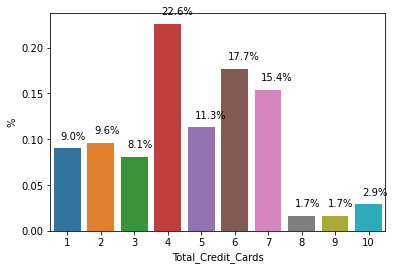

In [31]:
driver = 'Total_Credit_Cards'
_a = df[driver].value_counts(normalize=True).reset_index()
_a.columns = [driver, '%']
ax = sns.barplot(x=driver, y='%',data=_a)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height())
    x = p.get_x() + p.get_width()/4
    y = p.get_height()+0.01
    ax.annotate(percentage, (x, y))
plt.show()

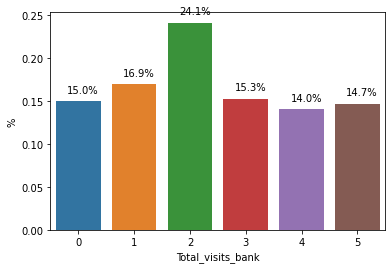

In [32]:
driver = 'Total_visits_bank'
_a = df[driver].value_counts(normalize=True).reset_index()
_a.columns = [driver, '%']
ax = sns.barplot(x=driver, y='%',data=_a)

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height())
    x = p.get_x() + p.get_width()/4
    y = p.get_height()+0.01
    ax.annotate(percentage, (x, y))
plt.show()

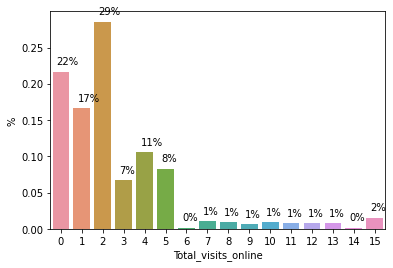

In [33]:
driver = 'Total_visits_online'
_a = df[driver].value_counts(normalize=True).reset_index()
_a.columns = [driver, '%']
ax = sns.barplot(x=driver, y='%',data=_a)
for p in ax.patches:
    percentage = '{:.0f}%'.format(100 * p.get_height())
    x = p.get_x() + p.get_width()/4
    y = p.get_height()+0.01
    ax.annotate(percentage, (x, y))
plt.show()

In [ ]:
def box_describe(df_copy):     df_stats = df_copy.describe().T     df_stats.rename(columns = {         '25%': 'q1',         '50%': 'q2',         '75%': 'q3'     }, inplace = True)          df_stats['iqr'] = df_stats['q3'] - df_stats['q1']     df_stats['lower_fence'] = df_stats['q1'] - (1.5 * df_stats['iqr'])  # Lower Fence     df_stats['upper_fence'] = df_stats['q3'] + (1.5 * df_stats['iqr'])  # Upper Fence          def get_outliers(series):         lower_outliers = (series < df_stats.loc[series.name].lower_fence).sum()         upper_outliers = (series > df_stats.loc[series.name].upper_fence).sum()         return lower_outliers + upper_outliers          df_stats['outliers'] = df_copy.apply(lambda x: get_outliers(x))     df_stats['outlier%'] = (df_stats['outliers'] / df_stats['count']) * 100          return df_stats 
    

In [49]:
# https://gist.github.com/VictorBezak/e6cb5c113a758e965f0e852e237bebe0

def box_describe(df_copy):
    df_stats = df_copy.describe().T
    df_stats.rename(columns = {
        '25%': 'q1',
        '50%': 'q2',
        '75%': 'q3'
    }, inplace = True)
    
    df_stats['iqr'] = df_stats['q3'] - df_stats['q1']
    df_stats['lower_fence'] = df_stats['q1'] - (1.5 * df_stats['iqr'])  # Lower Fence
    df_stats['upper_fence'] = df_stats['q3'] + (1.5 * df_stats['iqr'])  # Upper Fence
    
    def get_outliers(series):
        lower_outliers = (series < df_stats.loc[series.name].lower_fence).sum()
        upper_outliers = (series > df_stats.loc[series.name].upper_fence).sum()
        return lower_outliers + upper_outliers
    
    df_stats['outliers'] = df_copy.apply(lambda x: get_outliers(x))
    df_stats['outlier%'] = (df_stats['outliers'].values / df_stats['count']) * 100
    return df_stats

In [50]:
box_describe(df[['Avg_Credit_Limit']])

,count,mean,std,min,q1,q2,q3,max,iqr,lower_fence,upper_fence,outliers,outlier%
Avg_Credit_Limit,655.0,34563.358779,37648.200947,3000.0,10000.0,18000.0,48000.0,200000.0,38000.0,-47000.0,105000.0,39,5.954198


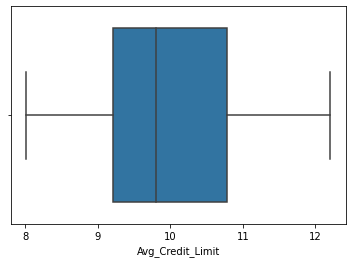

In [47]:
sns.boxplot(np.log(df['Avg_Credit_Limit']))
plt.show()

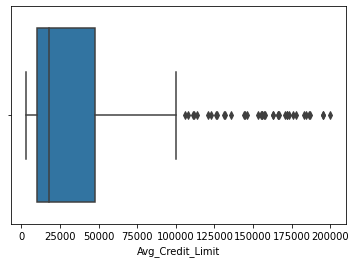

In [46]:
sns.boxplot(df['Avg_Credit_Limit'])
plt.show()

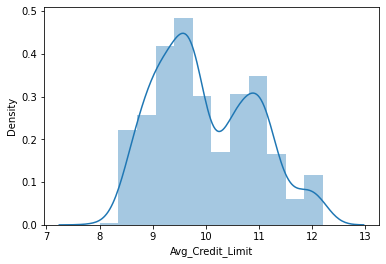

In [48]:
sns.distplot(np.log(df['Avg_Credit_Limit']), hist=True)
plt.show()

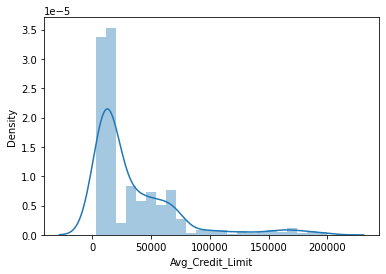

In [34]:
sns.distplot(df['Avg_Credit_Limit'], hist=True)
plt.show()

In [35]:
drop_colums=['Sl_No','Customer Key']

In [36]:
X = df.drop(columns=drop_colums)

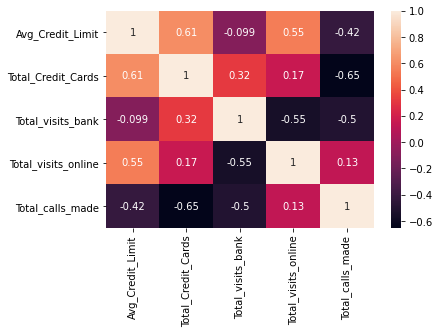

In [37]:
sns.heatmap(X.corr(),annot=True)
plt.show()

### K-Means
- Elbow Method
- Silehoutte

In [38]:
def k_means(X,
            standardize=True,
            silehoutte=False,
            show_silheoutte_visualization=False,
            elbow=True,
            cluster_range=range(1,10)):
    
    if standardize:
        X = StandardScaler().fit_transform(X)
    
    if elbow:
        meanDistortions=[]
        
        for cluster in cluster_range:
            model = KMeans(n_clusters=cluster, random_state=SEED)
            model.fit(X)
            prediction=model.predict(X)
            distortion=sum(np.min(cdist(X, model.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0]

            meanDistortions.append(distortion)

            print(cluster,distortion)

        plt.plot(cluster_range, meanDistortions, 'bx-')
        plt.xlabel('Cluster')
        plt.ylabel('Average distortion')
        plt.title('Selecting Cluster Size with the Elbow Method')
        plt.show()
        
        
    if silehoutte:
        
        for cluster in cluster_range:
            if cluster == 1:
                continue
                
            model = KMeans(n_clusters=cluster)
            model.fit(X)
            prediction=model.predict(X)
            
            silhouette_avg = silhouette_score(X, prediction)
            print(cluster, silhouette_avg)
    
    if show_silheoutte_visualization:
        visualize_silehoutte(X, cluster_range)
    

1 2.005608636921872
2 1.455402402901143
3 1.1467025891320393
4 1.0461484732614619
5 0.9905999657701369
6 0.9426810522531732
7 0.9092067256684445
8 0.8882232396314205
9 0.86588111239275


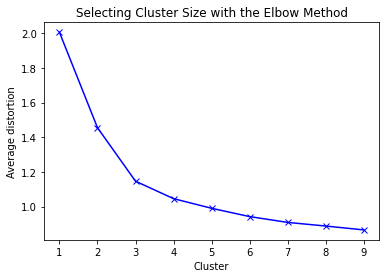

In [39]:
k_means(X, elbow=True, silehoutte=False, show_silheoutte_visualization=False)

In [ ]:
cluter_1 = [1,2,3,4,5]
cluster_2 = [6,7,8,9,10]
clsuter_3 = [11,12,13,14,15]

silehoutte_1:
    a = avg([dist(1, x) for x in [1,2,3,4,5]]) #average distance from all points in the same cluster
    
    a_cluster_2 = avg([dist(1, x) for x in [6,7,8,9,10]])
    a_cluster_3 = avg([dist(1, x) for x in [11,12,13,14,15]])
    
    b = min(a_cluster_2, a_cluster_3)

In [40]:
k_means(X, elbow=False, silehoutte=True)

2 0.4191048769542048
3 0.5156757893111308
4 0.35543523967554014
5 0.2722426275293033
6 0.25524399185447355
7 0.2485978523248886
8 0.22885614656397463
9 0.21360522034437052


Optimum number of cluster using K-means is 3

In [43]:
from visualize_silehoutte import *

PCA Explained variance: [0.45767565 0.37349905]
For n_clusters = 2 The average silhouette_score is : 0.4191048769539972
For n_clusters = 3 The average silhouette_score is : 0.5156757893108967
For n_clusters = 4 The average silhouette_score is : 0.3554352396746359
For n_clusters = 5 The average silhouette_score is : 0.2715562278808702


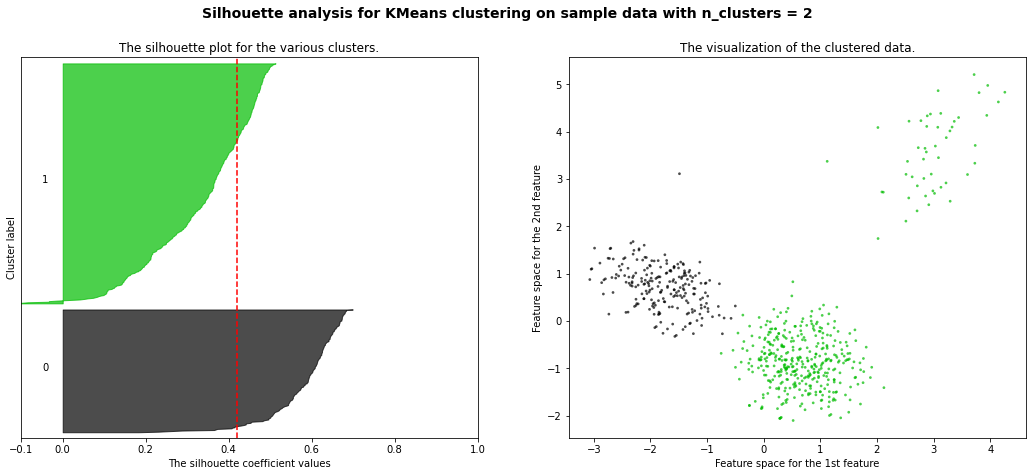

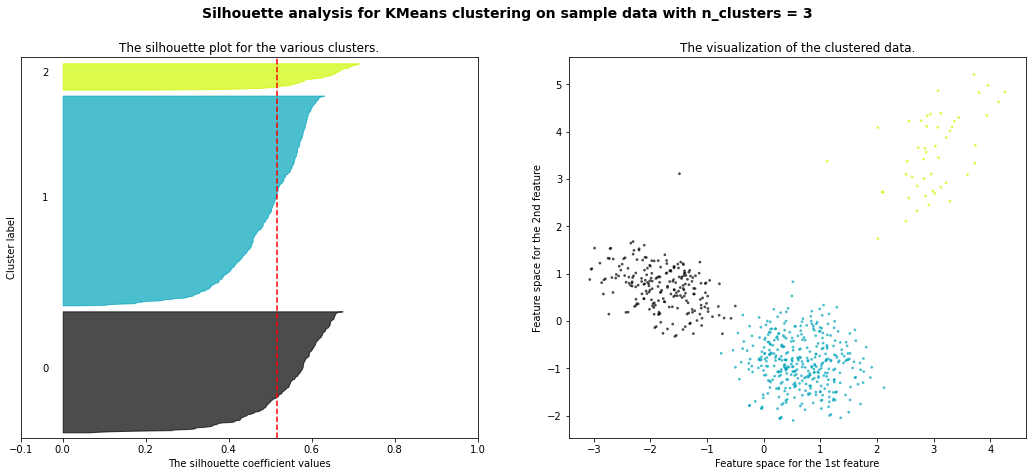

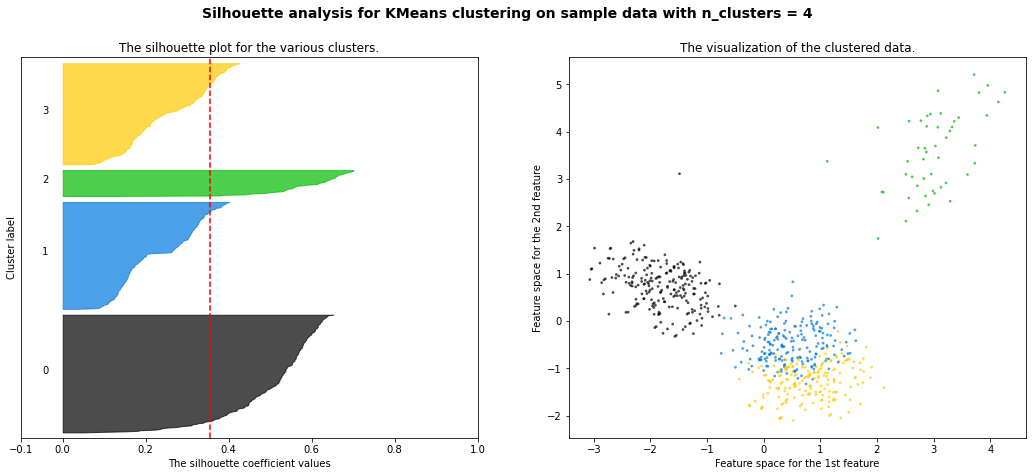

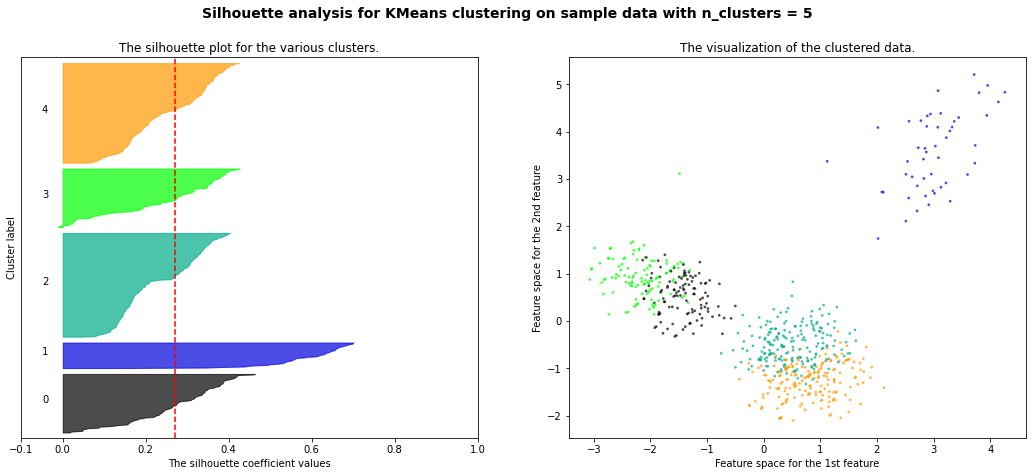

In [44]:
k_means(X, elbow=False, silehoutte=False, show_silheoutte_visualization=True,
       cluster_range=range(2,6))

In [51]:
feature_columns = df.columns.tolist()
feature_columns.remove('Customer Key')
feature_columns.remove('Sl_No')

In [52]:
feature_columns

['Avg_Credit_Limit',
 'Total_Credit_Cards',
 'Total_visits_bank',
 'Total_visits_online',
 'Total_calls_made']

In [59]:
X_std_df = pd.DataFrame(X_std, columns=X.columns)

In [58]:
type(X_std)

numpy.ndarray

In [53]:
X = df[feature_columns]
X_std = StandardScaler().fit_transform(X)
model = KMeans(n_clusters=3,random_state=SEED)
model.fit(X_std)
prediction=model.predict(X_std)

In [54]:
df['cluster'] = prediction

In [55]:
df['cluster'].value_counts(normalize=True)

1    0.586260
0    0.338931
2    0.074809
Name: cluster, dtype: float64

In [56]:
df.groupby(by='cluster')[feature_columns].agg('mean').round(2)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
cluster,,,,,
0,12180.18,2.41,0.94,3.57,6.85
1,33809.90,5.52,3.48,0.99,2.01
2,141877.55,8.80,0.61,10.88,1.04


In [ ]:
df.groupby(by='cluster')[feature_columns].agg('median').round(2)

In [62]:
X_std_df['cluster'] = prediction

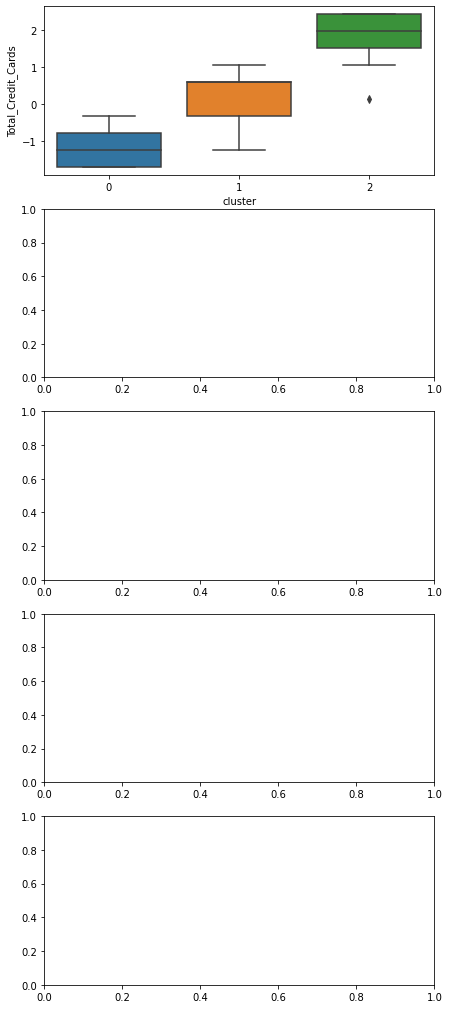

In [67]:
fig, axs = plt.subplots(nrows=5)
fig.set_size_inches(7, 18)
sns.boxplot(x='cluster', y='Total_Credit_Cards', data=X_std_df, ax=axs[0])
# sns.boxplot(x='cluster', y='Avg_Credit_Limit', data=X_std_df, ax=axs[1])
# sns.boxplot(x='cluster', y='Total_visits_bank', data=X_std_df, ax=axs[2])
# sns.boxplot(x='cluster', y='Total_visits_online', data=X_std_df, ax=axs[3])
# sns.boxplot(x='cluster', y='Total_calls_made', data=X_std_df, ax=axs[4])
plt.show()

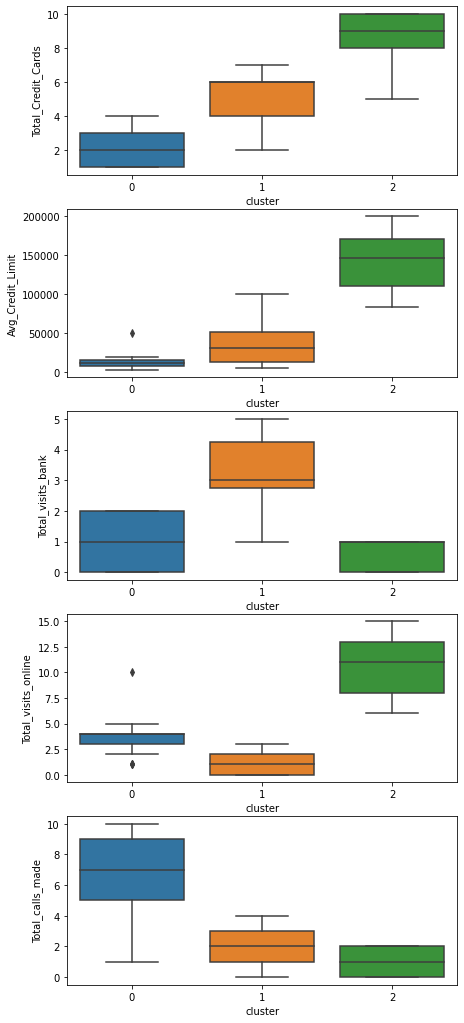

In [57]:
fig, axs = plt.subplots(nrows=5)
fig.set_size_inches(7, 18)
sns.boxplot(x='cluster', y='Total_Credit_Cards', data=df, ax=axs[0])
sns.boxplot(x='cluster', y='Avg_Credit_Limit', data=df, ax=axs[1])
sns.boxplot(x='cluster', y='Total_visits_bank', data=df, ax=axs[2])
sns.boxplot(x='cluster', y='Total_visits_online', data=df, ax=axs[3])
sns.boxplot(x='cluster', y='Total_calls_made', data=df, ax=axs[4])
plt.show()

### Cluster Description
    - ~ 7.5% customers with heavy credit card users; but more online presense
    - ~ 60% Customers prefer visiting banks; moderate credit card users
    - ~ 34% customers: low credit card users prefer calling [may be new customers]

- Status Quo
- Changing customer preference
- Survey
- Cost of different channels
- 

### Hierarchical Clustering

In [68]:
linkage_methods=['single','complete','average','ward','median']
metric_methods=['euclidean','mahalanobis']

results_cophenetic_coef=[]
for metric in metric_methods:
    for i in linkage_methods:
    
        try:
            Z = linkage(X, i, metric=metric)
        except:
            continue

        cc,cophn_dist = cophenet(Z, pdist(X, metric=metric))

        results_cophenetic_coef.append((i,metric,cc))


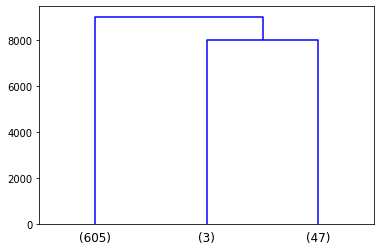

In [74]:
Z = linkage(X,
            method = 'single',
            metric='euclidean')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=3,
)
plt.show()

In [69]:

results_cophenetic_coef_df=pd.DataFrame(results_cophenetic_coef,columns=['LinkageMethod','MetricMethod','CopheneticCoefficient'])
results_cophenetic_coef_df.sort_values(by='CopheneticCoefficient', ascending=False)


,LinkageMethod,MetricMethod,CopheneticCoefficient
2,average,euclidean,0.905251
1,complete,euclidean,0.863038
0,single,euclidean,0.846293
4,median,euclidean,0.834170
7,average,mahalanobis,0.747191
3,ward,euclidean,0.736950
6,complete,mahalanobis,0.673407
5,single,mahalanobis,0.633554


In [ ]:
from visualize_silehoutte import visualize_silehoutte

PCA Explained variance: [0.45767565 0.37349905]
For n_clusters = 2 The average silhouette_score is : 0.5719574784552334
For n_clusters = 3 The average silhouette_score is : 0.5158844992916211
For n_clusters = 4 The average silhouette_score is : 0.4746821071182246


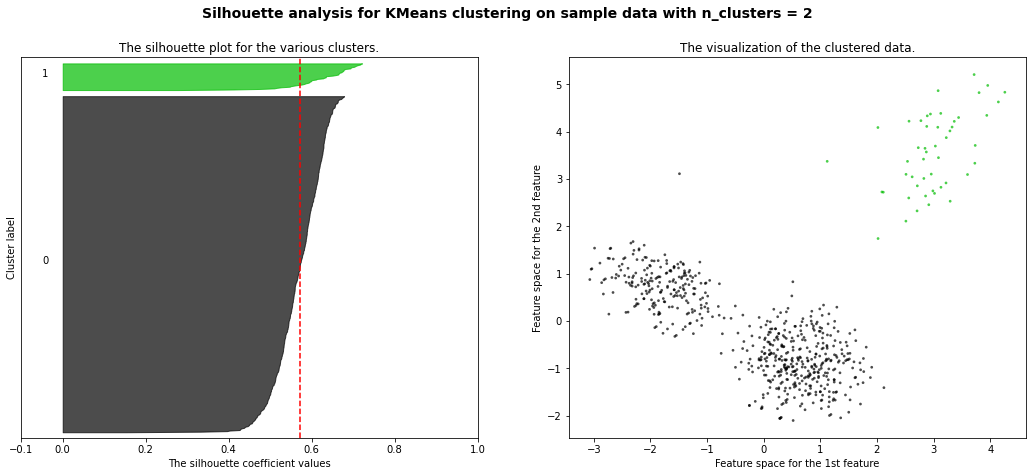

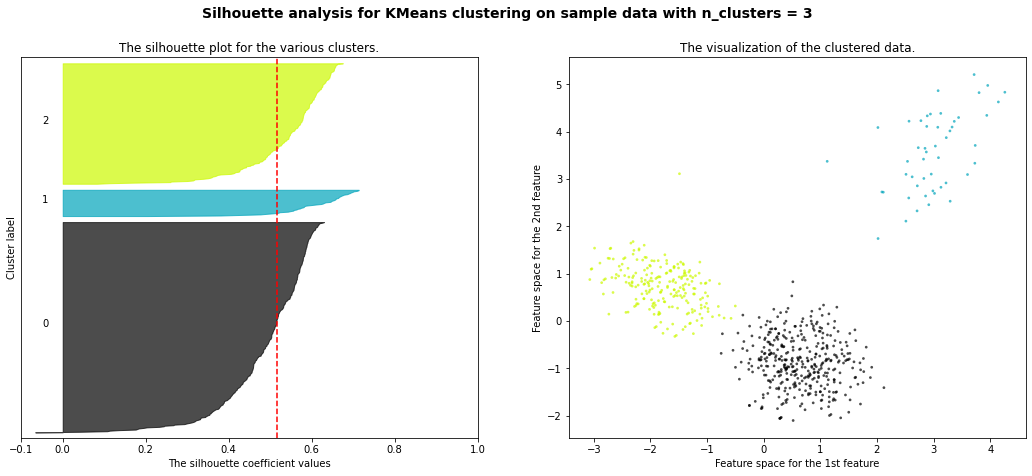

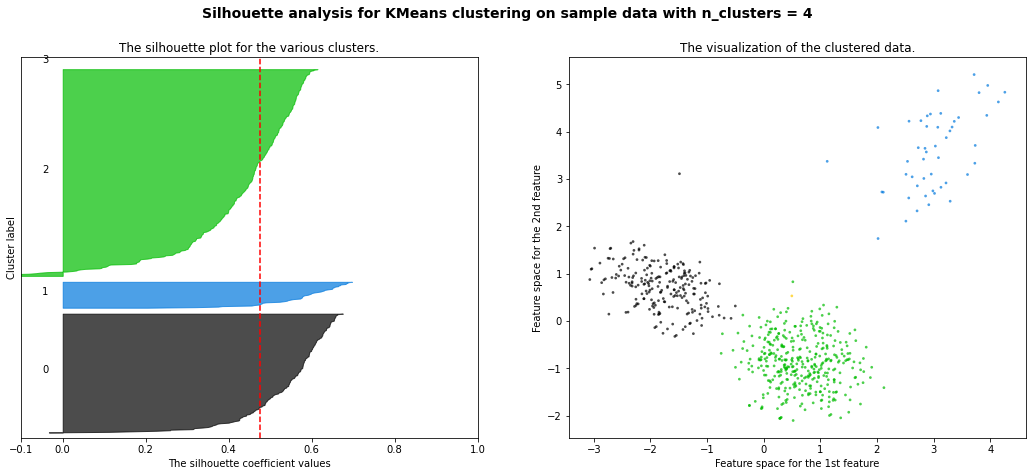

In [78]:
visualize_silehoutte(X, method='hierarchical', cluster_range=range(2,5))

In [ ]:
visualize_silehoutte(X, method='hierarchical', cluster_range=range(2,5))

In [ ]:
visualize_silehoutte(X, method='hierarchical', cluster_range=range(2,5))

In [ ]:
visualize_silehoutte(X, method='hierarchical')

In [81]:
X=df[['Avg_Credit_Limit_l', 'Total_Credit_Cards', 'Total_visits_bank',
       'Total_visits_online_1', 'Total_calls_made']]

In [80]:
df['Avg_Credit_Limit_l'] = np.log(df['Avg_Credit_Limit']+0.0001)
df['Total_visits_online_1'] = df['Total_visits_online'].clip(upper=8)

In [89]:
df['Total_visits_online_2'] = np.log(df['Total_visits_online']+1)

In [92]:
df['Total_visits_online_2'].std()

0.7069892811077431

In [ ]:
#yellowbricks
#visualizer = KElbowVisualizer(model, k=(2,10),metric='calinski_harabasz', timings= True)

In [91]:
df['Total_visits_online_2'].value_counts(normalize=True)

1.098612    0.285496
0.000000    0.216794
0.693147    0.166412
1.609438    0.105344
1.791759    0.082443
1.386294    0.067176
2.772589    0.015267
2.079442    0.010687
2.197225    0.009160
2.397895    0.009160
2.484907    0.007634
2.564949    0.007634
2.639057    0.007634
2.302585    0.006107
1.945910    0.001527
2.708050    0.001527
Name: Total_visits_online_2, dtype: float64

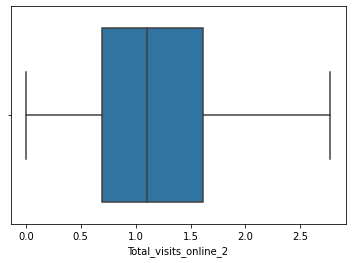

In [90]:
sns.boxplot(x='Total_visits_online_2', data=df)

In [82]:
df.skew()

Sl_No                   -0.001643
Customer Key             0.048520
Avg_Credit_Limit         2.209182
Total_Credit_Cards       0.140402
Total_visits_bank        0.140206
Total_visits_online      2.234473
Total_calls_made         0.658983
cluster                  0.133452
Avg_Credit_Limit_l       0.395117
Total_visits_online_1    1.094857
dtype: float64

In [83]:
X.skew()

Avg_Credit_Limit_l       0.395117
Total_Credit_Cards       0.140402
Total_visits_bank        0.140206
Total_visits_online_1    1.094857
Total_calls_made         0.658983
dtype: float64

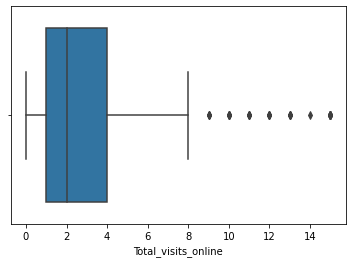

In [79]:
sns.boxplot(x='Total_visits_online', data=df)

In [ ]:
sns.boxplot(x='Avg_Credit_Limit', data=X)

In [84]:
X_std = StandardScaler().fit_transform(X)
ac_cluster = AgglomerativeClustering(n_clusters=3,
                                    linkage='complete',
                                    affinity='euclidean',
                                    )
cluster_labels = ac_cluster.fit_predict(X_std)
df['cluster_hierarchical'] = cluster_labels

In [88]:
X_std = StandardScaler().fit_transform(X)
ac_cluster = AgglomerativeClustering(n_clusters=2,
                                    linkage='complete',
                                    affinity='euclidean',
                                    )
cluster_labels = ac_cluster.fit_predict(X_std)
df['cluster_hierarchical'] = cluster_labels
df.groupby(by='cluster_hierarchical')[feature_columns].agg('mean').round(2)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
cluster_hierarchical,,,,,
0,25886.14,4.38,2.55,1.93,3.78
1,141877.55,8.80,0.61,10.88,1.04


In [86]:
df.groupby(by='cluster')[feature_columns].agg('mean').round(2)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
cluster,,,,,
0,12180.18,2.41,0.94,3.57,6.85
1,33809.90,5.52,3.48,0.99,2.01
2,141877.55,8.80,0.61,10.88,1.04


In [ ]:
df.groupby(by='cluster_hierarchical')[feature_columns].agg('mean')

In [ ]:
fig, axs = plt.subplots(nrows=5)
fig.set_size_inches(7, 18)
sns.boxplot(x='cluster_hierarchical', y='Total_Credit_Cards', data=df, ax=axs[0])
sns.boxplot(x='cluster_hierarchical', y='Avg_Credit_Limit', data=df, ax=axs[1])
sns.boxplot(x='cluster_hierarchical', y='Total_visits_bank', data=df, ax=axs[2])
sns.boxplot(x='cluster_hierarchical', y='Total_visits_online', data=df, ax=axs[3])
sns.boxplot(x='cluster_hierarchical', y='Total_calls_made', data=df, ax=axs[4])
plt.show()